#**PieInfocomm Final Project - Real/Fake Job postings Prediction**


> **Parameshwari S**

### 1. Importing all necessary libraries

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import nltk
import spacy
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score
from nltk.corpus import stopwords
stopwords = nlp.Defaults.stop_words
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lemma=WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import RMSprop
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 2. Reading the dataset

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Pie_Infocomm/fake_job_postings.csv")
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0


In [3]:
df.shape

(17880, 18)

### 3. Exploratory Data Analysis

In [4]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
df = df.fillna("")

In [7]:
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
dtype: int64

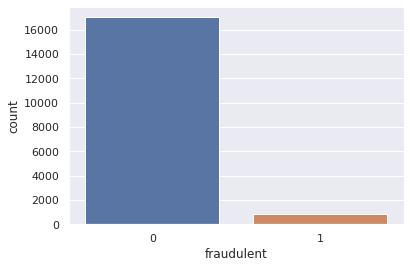

In [8]:
sns.set(style="darkgrid")
sns.countplot(x = "fraudulent" , data = df)

In [9]:
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function'] 
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,"Marketing Intern US, NY, New York Marketing We..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,"Customer Service - Cloud Video Production NZ, ..."
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,"Commissioning Machinery Assistant (CMA) US, IA..."


In [10]:
df.isnull().sum()

job_id                 0
title                  0
location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
text                   0
dtype: int64

### 4. Text preprocessing

In [11]:
df['text'][6]

"Head of Content (m/f) DE, BE, Berlin ANDROIDPIT Founded in 2009, the\xa0Fonpit AG\xa0rose with its international web portal\xa0ANDROIDPIT\xa0to the world's largest Android community. Every month over 18 Million Android and tech enthusiasts around the world log into\xa0ANDROIDPIT\xa0, where they know they'll find the latest and most innovative information about Android and Android-Apps in 6 different languages. Our business activities consist of close collaboration with many of the world's largest tech, web and mobile companies.In 2014,\xa0APP MEDIA\xa0amended Fonpit AG’s brand portfolio. As a one-stop shop for app marketing,APP MEDIA\xa0delivers quality performance marketing for apps to give clients the most successful campaigns possible with custom concepts and sustainable results.Located in the heart of Berlin, we are constantly looking for highly motivated and success driven personalities to help\xa0ANDROIDPIT\xa0and\xa0APP MEDIA\xa0grow even further. Your Responsibilities:\xa0Mana

In [12]:
def remove_urls(text):
  text = text.lower()
  text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
  return text

def remove_special_char(text):
  text = re.sub(r'[^a-zA-Z0-9\s]+', '', text)
  return text

def remove_num(text):
  text = re.sub(r'\d+', ' ', text)
  return text

def remove_single_char(text):
  text = re.sub(r'\s[a-zA-Z]\s', ' ', text)
  return text

def remove_extra_space(text):
  text = re.sub(r'\s+', ' ', text)
  return text

def clean(text):
  tokens=word_tokenize(text)
  tokens_stop=[word for word in tokens if word not in stopwords]
  lemmatized_words=[lemma.lemmatize(token) for token in tokens if len(token)>2]
  clean_text=' '.join(lemmatized_words)
  return clean_text

In [13]:
df['text'] = df['text'].apply(remove_urls)
df['text'] = df['text'].apply(remove_special_char)
df['text'] = df['text'].apply(remove_num)
df['text'] = df['text'].apply(remove_single_char)
df['text'] = df['text'].apply(remove_extra_space)
df['text'] = df['text'].apply(clean)
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,marketing intern new york marketing were food ...
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,customer service cloud video production auckla...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,commissioning machinery assistant cma wever va...


### 5. Vectorization and Train-test-split

In [14]:
cv = CountVectorizer(max_features = 3000)
x_bow = cv.fit_transform(df['text']).toarray()
df1 = pd.DataFrame(data = x_bow, columns = cv.get_feature_names())
df1.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aabbf,abc,ability,able,about,above,abroad,absolutely,academic,accept,...,youll,young,your,youre,yourself,youth,youve,zealand,zero,zone
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,4,0,0,0,0,0,...,0,0,6,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,2,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,3,0,0,0,0,0,0,0


In [15]:
X_train_bow, X_val_bow, y_train_bow, y_val_bow = train_test_split(df1.values, df['fraudulent'], test_size=0.20, random_state=0)

In [16]:
tfidf = TfidfVectorizer(max_features = 3000)
x_tfidf = tfidf.fit_transform(df['text']).toarray()
df2 = pd.DataFrame(data = x_tfidf, columns = tfidf.get_feature_names())
df2.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aabbf,abc,ability,able,about,above,abroad,absolutely,academic,accept,...,youll,young,your,youre,yourself,youth,youve,zealand,zero,zone
0,0.0,0.0,0.000000,0.000000,0.023078,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.012543,0.045285,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.053537,0.0,0.021705,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.045310,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.016859,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.041457,0.0,0.000000,0.0,0.0,0.0,0.097942,0.0
4,0.0,0.0,0.000000,0.027781,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.059287,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [17]:
X_train_tfidf, X_val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(df2.values, df['fraudulent'], test_size=0.20, random_state=0)

### 6. Evaluation

> a. Logistic Regression



In [20]:
lr = LogisticRegression()
lr.fit(X_train_bow,y_train_bow)
lr_y_pred_bow = lr.predict(X_val_bow)
acc_bow_lr = accuracy_score(lr_y_pred_bow, y_val_bow)
print('Accuracy:', acc_bow_lr)

Accuracy: 0.9809843400447428


In [21]:
lr = LogisticRegression()
lr.fit(X_train_tfidf,y_train_tfidf)
lr_y_pred_tfidf = lr.predict(X_val_tfidf)
acc_tfidf_lr = accuracy_score(lr_y_pred_tfidf, y_val_tfidf)
print('Accuracy:', acc_tfidf_lr)

Accuracy: 0.9762304250559284




> b. Linear SVM



In [23]:
svc = LinearSVC()
svc.fit(X_train_bow,y_train_bow)
svc_y_pred_bow = svc.predict(X_val_bow)
acc_bow_svm = accuracy_score(svc_y_pred_bow, y_val_bow) 
print('Accuracy:', acc_bow_svm)

Accuracy: 0.9706375838926175


In [24]:
svc = LinearSVC()
svc.fit(X_train_tfidf,y_train_tfidf)
svc_y_pred_tfidf = svc.predict(X_val_tfidf)
acc_tfidf_svm = accuracy_score(svc_y_pred_tfidf, y_val_tfidf)
print('Accuracy:', accuracy_score(svc_y_pred_tfidf, y_val_tfidf))

Accuracy: 0.9840604026845637




> c. Naive-Bayes



In [25]:
nb = MultinomialNB()
nb.fit(X_train_bow,y_train_bow)
nb_y_pred_bow = nb.predict(X_val_bow)
acc_bow_nb = accuracy_score(nb_y_pred_bow, y_val_bow)
print('Accuracy:', acc_bow_nb)

Accuracy: 0.9012863534675615


In [26]:
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train_tfidf)
nb_y_pred_tfidf = nb.predict(X_val_tfidf)
acc_tfidf_nb = accuracy_score(nb_y_pred_tfidf, y_val_tfidf)
print('Accuracy:', accuracy_score(nb_y_pred_tfidf, y_val_tfidf))

Accuracy: 0.9695190156599552




> d. CNN with Word Embeddings



In [27]:
le = LabelEncoder()
fraud = le.fit_transform(df['fraudulent'])

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], fraud, test_size = 0.20, random_state = 100)

In [31]:
tokenizer = Tokenizer(num_words = 3000)
tokenizer.fit_on_texts(x_train)
xcnn_train = tokenizer.texts_to_sequences(x_train)
xcnn_test = tokenizer.texts_to_sequences(x_test)
vocab_size = len(tokenizer.word_index) + 1

In [32]:
ycnn_train = to_categorical(y_train)
ycnn_test = to_categorical(y_test)

In [34]:
max_len = 200
xcnn_train = pad_sequences(xcnn_train, padding = 'post', maxlen = max_len)
xcnn_test = pad_sequences(xcnn_test, padding = 'post', maxlen = max_len)
print(xcnn_train[0, :])

[   1  945 1897 1842    1 2449    1  692  160 1169   80  504   74  316
  164  310    1 1050 1040   30 1141  164  365  252 1800  164 1057   52
 1355  729    1   86  242  240  112 2103    1  714 1604    3 1071 1077
    1  365  624   56    1   17   13   26  200    2   14  171 2584  521
 1743    1 2833 1985   43   26   67    1  846    2 2488    1  144  481
   86    2  166    2  434 1185 1693  237  367    1   14  340    1   17
  763   95  172  101 2431   17   59   36  110   48 1485    1  519 1214
  519 1214    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [45]:
embedding_dim = 200
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length = max_len))
model.add(layers.Conv1D(128, 5, activation = 'relu'))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(2, activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 200)          26660800  
                                                                 
 conv1d_3 (Conv1D)           (None, 196, 128)          128128    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 512)               66048     
                                                                 
 dense_7 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 26,856,002
Trainable params: 26,856,002
Non-trainable params: 0
__________________________________________

In [47]:
model.fit(xcnn_train, ycnn_train, epochs = 5, validation_data = (xcnn_test, ycnn_test), batch_size = 100)
loss_word_emb, accuracy_word_emb = model.evaluate(xcnn_train, ycnn_train, verbose = False)
print("Training accuracy - ", accuracy_word_emb)
print("Training loss - ", loss_word_emb)

Epoch 1/5
144/144 [==============================] - 93s 642ms/step - loss: 0.1762 - accuracy: 0.9476 - val_loss: 0.1356 - val_accuracy: 0.9519
Epoch 2/5
144/144 [==============================] - 119s 828ms/step - loss: 0.0752 - accuracy: 0.9758 - val_loss: 0.1003 - val_accuracy: 0.9695
Epoch 3/5
144/144 [==============================] - 113s 782ms/step - loss: 0.0271 - accuracy: 0.9919 - val_loss: 0.1243 - val_accuracy: 0.9723
Epoch 4/5
144/144 [==============================] - 96s 665ms/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.1586 - val_accuracy: 0.9729
Epoch 5/5
144/144 [==============================] - 126s 879ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.1576 - val_accuracy: 0.9740
Training accuracy -  0.9997203350067139
Training loss -  0.001295555499382317




> e. LSTM



In [48]:
x=df.text
y=df.fraudulent
le=LabelEncoder()
y=le.fit_transform(y)
y=y.reshape(-1,1)

In [49]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.15)

In [51]:
max_words = 3000
max_len = 200
tok = Tokenizer(num_words = max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

In [55]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [56]:
model = RNN()
model.summary()
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(), metrics = ['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 200)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 200, 50)           150000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [57]:
model.fit(sequences_matrix, y_train, batch_size = 128, epochs = 5, validation_split = 0.2)

Epoch 1/5
95/95 [==============================] - 73s 743ms/step - loss: 0.1908 - accuracy: 0.9478 - val_loss: 0.1440 - val_accuracy: 0.9632
Epoch 2/5
95/95 [==============================] - 31s 326ms/step - loss: 0.0934 - accuracy: 0.9733 - val_loss: 0.0923 - val_accuracy: 0.9720
Epoch 3/5
95/95 [==============================] - 24s 257ms/step - loss: 0.0722 - accuracy: 0.9785 - val_loss: 0.0881 - val_accuracy: 0.9740
Epoch 4/5
95/95 [==============================] - 24s 257ms/step - loss: 0.0598 - accuracy: 0.9822 - val_loss: 0.0884 - val_accuracy: 0.9711
Epoch 5/5
95/95 [==============================] - 26s 275ms/step - loss: 0.0504 - accuracy: 0.9845 - val_loss: 0.0903 - val_accuracy: 0.9750


In [58]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [59]:
loss, acc_lstm = model.evaluate(test_sequences_matrix, y_test)
print("Accuracy - ", acc_lstm *100)

84/84 [==============================] - 2s 29ms/step - loss: 0.0917 - accuracy: 0.9735
Accuracy -  97.3527193069458


### 7. Comparison of Accuracies

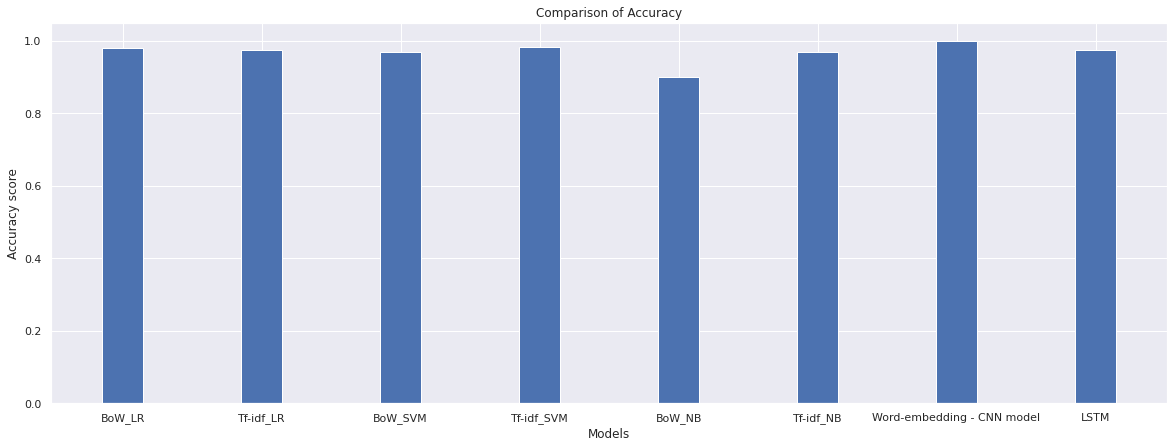

In [61]:
data_dict = {'BoW_LR':acc_bow_lr, 'Tf-idf_LR':acc_tfidf_lr, 'BoW_SVM':acc_bow_svm, 'Tf-idf_SVM':acc_tfidf_svm, 'BoW_NB':acc_bow_nb, 'Tf-idf_NB':acc_tfidf_nb, 'Word-embedding - CNN model':accuracy_word_emb, 'LSTM':acc_lstm}
x = list(data_dict.keys())
y = list(data_dict.values())
fig = plt.figure(figsize = (20, 7))
plt.bar(x, y,width = 0.3)
plt.xlabel("Models")
plt.ylabel("Accuracy score")
plt.title("Comparison of Accuracy")
plt.show()